In [13]:
import librosa
import numpy as np
import tensorflow as tf
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import scipy.fftpack as fftpack
import scipy.signal as signal
import soundfile as sf
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [14]:
def load_audio(audio_file_path):
    audio, sr = librosa.load(audio_file_path, sr=44100)
    return audio, sr

def load_model(model_path):
    model = tf.keras.models.load_model(model_path)
    return model

In [15]:
def extract_features(audio, sr):
    """
    Extracts multiple audio features (MFCC, Chroma STFT, Chroma CQT, Chroma CENS) from the audio signal.
    Returns a 3D vector (time, frequency, feature).
    """
    # Feature 1: MFCC
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)

    # Feature 2: Chroma STFT
    chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sr)
    chroma_stft_mean = np.mean(chroma_stft, axis=1)

    # Feature 3: Chroma CQT with reduced bins
    chroma_cqt = librosa.feature.chroma_cqt(y=audio, sr=sr, bins_per_octave=24, n_octaves=7)
    chroma_cqt_mean = np.mean(chroma_cqt, axis=1)

    # Feature 4: Chroma CENS
    chroma_cens = librosa.feature.chroma_cens(y=audio, sr=sr)
    chroma_cens_mean = np.mean(chroma_cens, axis=1)

    # Combine all features into a single vector
    return np.hstack([mfcc_mean, chroma_stft_mean, chroma_cqt_mean, chroma_cens_mean])


In [16]:
audio_file_path = "71173-2-0-21.wav"
audio,sr=load_audio(audio_file_path)
features = extract_features(audio,sr)
features

array([-4.9998697e+02,  1.6918381e+02, -1.6625591e+01,  2.5940817e+01,
        4.9667301e+00,  2.8095193e+00,  5.6594014e+00, -2.3122163e+00,
       -1.0496324e+00,  2.4890332e+00, -5.4143608e-01,  4.4796176e+00,
       -1.9266044e+00,  5.5219662e-01,  5.9996301e-01,  5.8936656e-01,
        5.2808398e-01,  4.8672003e-01,  4.5525610e-01,  4.9305168e-01,
        5.1470059e-01,  5.2517349e-01,  5.1066375e-01,  5.2952325e-01,
        5.4418159e-01,  8.0322546e-01,  8.1817359e-01,  8.3267480e-01,
        8.2513851e-01,  6.8535751e-01,  6.4038771e-01,  5.5416501e-01,
        6.0338402e-01,  6.2211835e-01,  5.5836630e-01,  5.2256435e-01,
        5.8243597e-01,  3.8550648e-01,  3.6688730e-01,  3.5713342e-01,
        3.5521734e-01,  2.5212458e-01,  2.3570164e-01,  2.2524874e-01,
        2.5434741e-01,  2.3690878e-01,  2.2015482e-01,  2.0076236e-01,
        2.2966044e-01], dtype=float32)

In [17]:
features=features.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_features = scaler.fit_transform(features)

In [18]:
scaled_features = scaled_features.reshape(-1, 1, 49, 1)

In [19]:
model = load_model("trained_cnn_model.h5")
predictions = model.predict(scaled_features)
print(np.argmax(predictions))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
2


In [20]:
# Step 1: Map prediction index to noise type
noise_classes = [
    "air_conditioner", "car_horn", "children_playing", "dog_bark",
    "drilling", "engine_idling", "gun_shot", "jackhammer",
    "siren", "street_music"
]

predicted_index = np.argmax(predictions)
predicted_noise_type = noise_classes[predicted_index]
print(f"Predicted Noise Type: {predicted_noise_type}")

# Step 2: Select threshold based on predicted noise type
noise_thresholds = {
    "air_conditioner": 0.05,
    "car_horn": 0.1,
    "children_playing": 0.15,
    "dog_bark": 0.2,
    "drilling": 0.25,
    "engine_idling": 0.1,
    "gun_shot": 0.3,
    "jackhammer": 0.35,
    "siren": 0.2,
    "street_music": 0.15
}

threshold = noise_thresholds[predicted_noise_type]
print(f"Selected Threshold for {predicted_noise_type}: {threshold}")

# Step 3: Compute FFT and create noise mask
signal_fft = fftpack.fft(audio)
signal_power = np.abs(signal_fft) ** 2

# Generate mask
mask = signal_power > threshold
mask = mask.astype(float)

# Apply mask to reduce noise
reduced_fft = signal_fft * mask
denoised_audio = np.real(fftpack.ifft(reduced_fft))

# Step 4: Save the denoised audio
sf.write("denoised_output.wav", denoised_audio, sr)
print("Denoised audio saved as 'denoised_output.wav'.")

Predicted Noise Type: children_playing
Selected Threshold for children_playing: 0.15
Denoised audio saved as 'denoised_output.wav'.


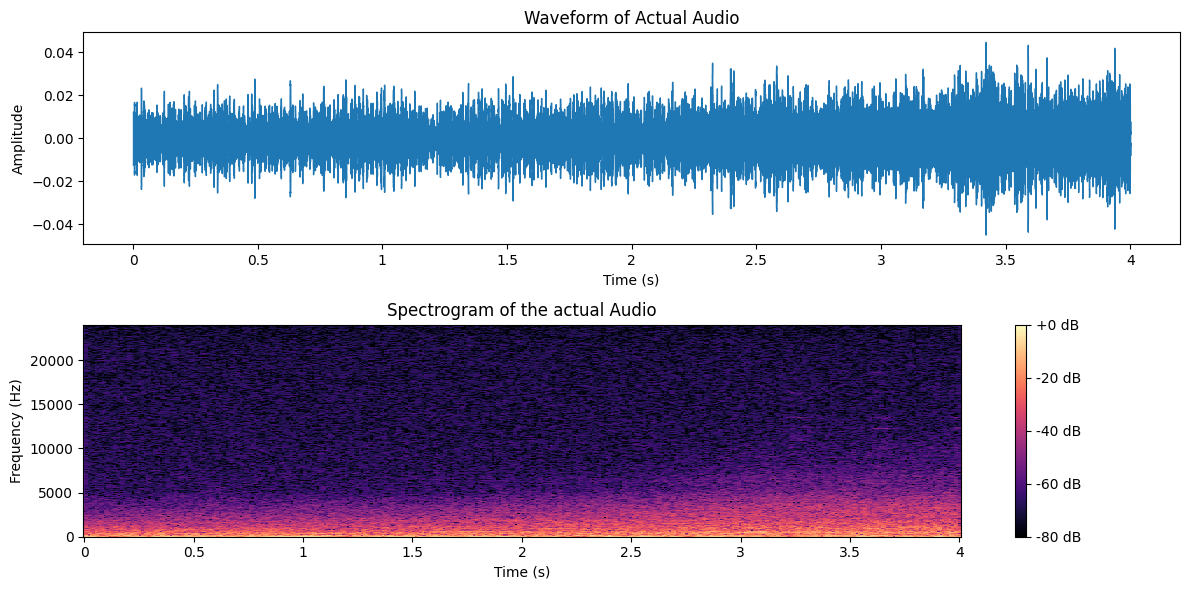

In [21]:
audio_path = "178686-0-0-34.wav"
audio, sr = librosa.load(audio_path, sr=None)

# Step 2: Plot the waveform
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
librosa.display.waveshow(audio, sr=sr)
plt.title("Waveform of Actual Audio")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Step 3: Compute and plot the spectrogram
plt.subplot(2, 1, 2)
S = librosa.stft(audio)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="hz", cmap="magma")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram of the actual Audio")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

# Step 4: Show the plots
plt.tight_layout()
plt.show()

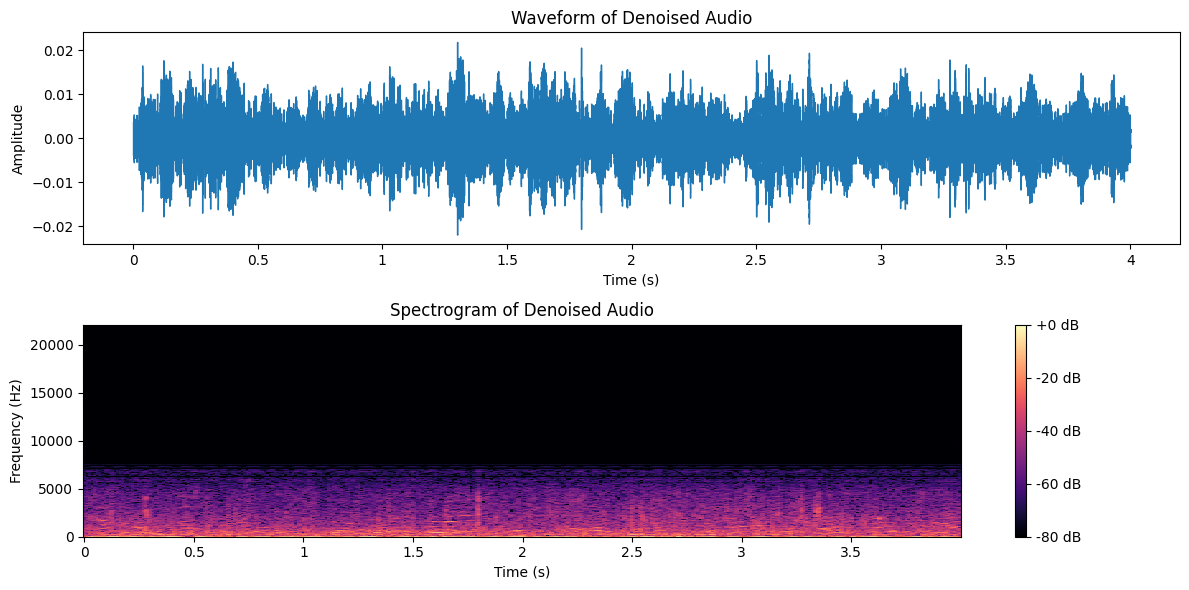

In [22]:
audio_path = "denoised_output.wav"
audio, sr = librosa.load(audio_path, sr=None)

# Step 2: Plot the waveform
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
librosa.display.waveshow(audio, sr=sr)
plt.title("Waveform of Denoised Audio")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Step 3: Compute and plot the spectrogram
plt.subplot(2, 1, 2)
S = librosa.stft(audio)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="hz", cmap="magma")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram of Denoised Audio")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

# Step 4: Show the plots
plt.tight_layout()
plt.show()